### Program written by Scott Midgley, 2021
Scope: To train and test LR models for mixing energy screening in the configuraional space of MgO-ZnO solid solutions. 

In [1]:
### USER INPUT REQUIRED ###

# Please paste in the path to the repositiory here an comment/uncomment as needed.
# E.g. rundir = r'C:\Users\<user>\Desktop\repository'

# Windows path
#repodir = r'<windows\path\here>'
#repodir = r'C:\Users\smidg\Desktop\ml\repository'

#Unix path
repodir = r'/home/mts87985/ml-thermo/Machine-Learning-for-Solid-Solutions/'

In [2]:
### USER INPUT REQUIRED ###

# Define percentage of training data to use for training. 
split = 10
#split = 50
#split = 80
#split = 30

In [3]:
# Import modules. 
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import pickle
import os
import time
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import os

## Load the data

Note we do not shuffle in this case. The data was shuffled when created and we are keeping it un-shuffled here so that the order is the same as that used in the paper. However, you are free to add a shuffle if you like.

In [4]:
# Import data and shuffle (optional).
eners = pd.read_pickle(repodir + 'repository-data/cluster_correlation_functions/input_data_ccf.pkl')
#eners = eners.sample(frac=1)

In [5]:
# Calculate mixing energies based on total DFT energy of phase separated end members. Add emix to data frame.  
Emg_end = -381.17925146/32
Ezn_end = -317.49620269/36
Emg_end = 24 * Emg_end
Ezn_end = 8 * Ezn_end
emix = eners['SCF'] - (Emg_end + Ezn_end)
eners['Emix'] = emix

In [6]:
# Split data frame into training, validation, and testing data. 
if split == int(10):
    e_train = eners.iloc[1608:2412] #10% of data for training
elif split == int(30):
    e_train = eners.iloc[1608:4021] #30% of data for training
elif split == int(50):
    e_train = eners.iloc[1608:5630] #50% of data for training
elif split == int(80):
    e_train = eners.iloc[1608:] #80% of data for training
else:
    print('Error: please choose a valid train/test split.')
e_val = eners.iloc[804:1608] #10% of data for validation
e_test = eners.iloc[:804] #10% of data for testing model

In [7]:
# Convert Pandas columns to Numpy arrays. Reshaping to obtain array of nested brackets. 
Xtrain = e_train['cf_vector'].to_numpy()
ytrain = e_train['Emix'].to_numpy()
Xtrain = np.stack(Xtrain)
ytrain= np.stack(ytrain) 
Xval = e_val['cf_vector'].to_numpy()
yval = e_val['Emix'].to_numpy()
Xval = np.stack(Xval)
yval= np.stack(yval)
Xtest = e_test['cf_vector'].to_numpy()
ytest = e_test['Emix'].to_numpy()
Xtest = np.stack(Xtest)
ytest = np.stack(ytest)

In [8]:
# Define Lasso regularized regressor. 
lasso_reg = Lasso(alpha=0.000001)
lasso_reg.fit(Xtrain, ytrain)

/home/mts87985/anaconda3/envs/ml-solid-solns/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.12275474749713666, tolerance: 7.849609031695078e-05
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=1e-06)

In [9]:
# Print regressor metrics.
r_sq = ('R^2:  ', lasso_reg.score(Xtrain, ytrain))
inter = ('intercept: ', lasso_reg.intercept_)
coef = ('coefficient:  ', lasso_reg.coef_)
print(r_sq)
print(inter)
print(coef)

('R^2:  ', 0.6190614588865937)
('intercept: ', 2.4053495473728876)
('coefficient:  ', array([-1.83592624e-05, -1.65489743e-03, -2.40338743e-03,  5.49897340e-06,
       -2.63430830e-04,  1.34988160e-03, -4.79486111e-05,  1.60635051e-04,
       -5.28264207e-04,  8.44782172e-05,  3.28519834e-04,  1.43184987e-06,
       -1.59932809e-04,  7.96734799e-04, -1.09521843e-04,  3.23356899e-05,
        5.21240393e-04, -5.90689032e-05, -1.32607310e-04,  5.69238102e-05,
        1.10667038e-03,  6.68928946e-05, -2.28946246e-04, -3.01254037e-05,
       -1.42116619e-04,  1.49364871e-04, -2.99608318e-04,  1.42012486e-04,
       -2.62487716e-05,  3.25540911e-04, -7.57235330e-05,  7.83736659e-05,
        1.54114531e-04, -1.13389665e-04, -1.09761857e-05, -1.34752248e-04,
       -2.91787742e-05,  6.22260365e-05, -1.47340279e-05,  2.56269243e-04,
       -1.73597147e-04, -3.58327149e-04, -1.61689433e-04, -3.67923811e-04,
       -5.38587088e-05, -2.67263468e-06, -1.34429456e-04, -4.66887607e-05,
        7.5386

In [10]:
# Test the regressor. 
ypred = lasso_reg.predict(Xtest)

In [11]:
# Add metrics to data frame. 
mae = ('MAE:  ', mean_absolute_error(ytest, ypred))
print('mae = ', mae)

mae =  ('MAE:  ', 0.026516918360388903)


Text(0, 0.5, 'Regressor')

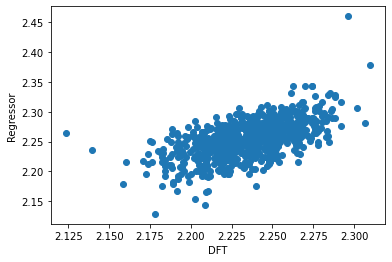

In [12]:
#Plot DFT mixing energy vs regressor predicted.
plt.scatter(ytest, ypred)
plt.xlabel('DFT')
plt.ylabel('Regressor')
#plt.savefig('BGE_pred_vs_val.png')